In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE             # ↩︎ **NEW** oversampler
from imblearn.pipeline      import Pipeline          # ↩︎ **NEW** imbalanced-learn pipeline
from collections import Counter
from sklearn.metrics        import roc_auc_score
from sklearn.compose      import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [2]:
df=pd.read_csv('unusual_drop_preprocess_all_v4.csv')

In [3]:
raw_df=pd.read_csv('lending_club_2020_train.csv')

/var/folders/8l/bz01tth90yv2m27jxhbcncfw0000gn/T/ipykernel_71051/2426208817.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df=pd.read_csv('lending_club_2020_train.csv')


In [4]:
# 변수 목록 불러오기
with open('selected_cols_v1.txt', 'r', encoding='utf-8') as f:
    selected_cols_v1 = [line.strip() for line in f if line.strip()]

In [5]:
df_sel = df[selected_cols_v1]
df_sel = pd.concat([df_sel, df['int_rate'], df['treasury'], df['loan_status'], df['funded_amnt'], df['irr']], axis=1)

In [6]:
with open('categorical_cols_v1.txt', 'r', encoding='utf-8') as f:
    cat_columns_v1 = [line.strip() for line in f if line.strip() != '']

In [7]:
df_cat = df[cat_columns_v1]

In [8]:
# 범주형 변수들 -> 원핫인코딩
# columns=cat_columns_v1 (리스트 그대로 전달)
df_cat = pd.get_dummies(df_cat, drop_first=True)

# 원본 컬럼 제거: 이미 get_dummies에서 제거되므로, 보통 이 라인은 필요 없음
# 하지만 혹시 모르니 아래처럼, 변수명을 일치시키세요.
df_cat = df_cat.drop(cat_columns_v1, axis=1, errors='ignore')

In [9]:
df_sel = pd.concat([df_sel, df_cat], axis = 1)

In [10]:
# 범주형 변수 남아있는지 체크
obj_cols = df_sel.select_dtypes(include='object').columns
if len(obj_cols) > 0:
    print("아직 문자열 변수 존재:", obj_cols)

In [11]:
# 컬럼 이름 깨짐 방지
df_sel.columns = df_sel.columns.str.replace(r'[\[\]<>]', '_', regex=True)

In [12]:
# 타겟/입력 변수 분리
X = df_sel.drop('loan_status', axis=1)
y = df_sel['loan_status']


In [13]:
# 데이터 분할
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
X_tr = X_tr.copy()
X_val = X_val.copy()

# risk_free 컬럼 생성
X_tr['risk_free'] = X_tr['treasury']
X_val['risk_free'] = X_val['treasury']

drop_cols = ['irr', 'funded_amnt']
X_train = X_tr.drop(columns=drop_cols)
X_valid = X_val.drop(columns=drop_cols)

# 3. 수치형/범주형 분리
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = [col for col in X_train.columns if col not in num_cols]

num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = [c for c in X_train.columns if c not in num_cols]

# 4. 파이프라인 구성
pipe = Pipeline(steps=[
    ('prep', ColumnTransformer([
        ('num', StandardScaler(with_mean=False), num_cols),
        ('cat', 'passthrough', cat_cols)
    ])),
    ('smote', SMOTE(random_state=2025)),
    ('xgb', XGBClassifier(
        n_jobs=-1,
        random_state=42,
        max_depth=3,
        learning_rate=0.1,
        min_child_weight=5,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss'
    ))
])

# (4) 학습
pipe.fit(X_train, y_tr)

# (5) 검증 세트 예측 확률
val_pred_prob = pipe.predict_proba(X_valid)[:, 1]

# (선택) AUC 점검
print("Validation AUC :", roc_auc_score(y_val, val_pred_prob))

/opt/anaconda3/envs/xgb/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:26:01] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation AUC : 0.7023826943392779


In [14]:
def calc_sharpe_by_thresholds_stat_econ(model, X_val_model, X_val, y_val, irr_col='irr', treasury_col='treasury'):
    # X_val_model: drop_cols가 이미 적용된 DataFrame
    val_pred_prob = model.predict_proba(X_val_model)[:, 1]
    thresholds = np.linspace(0.01, 0.99, 100)
    sharpe_ratios = []

    for t in thresholds:
        val_binary = np.where(val_pred_prob > t, 1, 0)
        val_return = []
        for pred, actual, irr, treasury in zip(val_binary, y_val, X_val[irr_col], X_val[treasury_col]):
            if pred == 0:
                val_return.append(irr)
            else:
                val_return.append(treasury - irr)
        val_return = np.array(val_return)          #실제수익률
        risk_free = np.array(X_val[treasury_col])  #국채수익률
        excess_ret = val_return - risk_free        #초과수익률
        if excess_ret.std() > 0:
            sharpe = excess_ret.mean() / excess_ret.std()
        else:
            sharpe = np.nan
        sharpe_ratios.append(sharpe)
    return thresholds, sharpe_ratios


In [16]:
thresholds, sharpe_ratios = calc_sharpe_by_thresholds_stat_econ(
    model=pipe,
    X_val_model=X_valid,  # <- drop된 DataFrame
    X_val=X_val,              # <- 원본(irr, treasury 정보 있음)
    y_val=y_val,
    irr_col='irr',
    treasury_col='treasury'
)


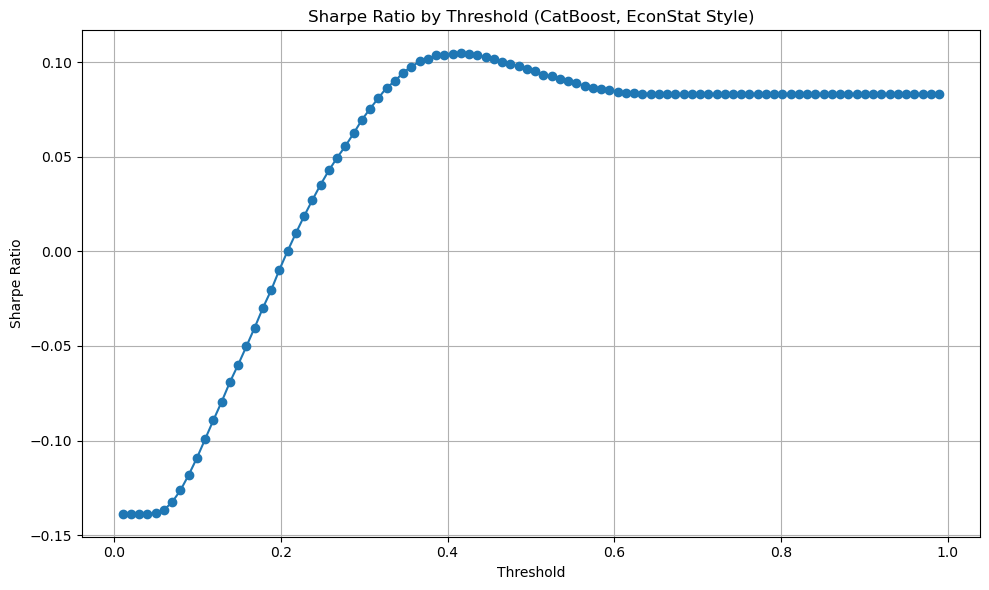

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, sharpe_ratios, marker='o')
plt.xlabel("Threshold")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio by Threshold (CatBoost, EconStat Style)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
import numpy as np

sharpe_arr = np.array(sharpe_ratios)
threshold_arr = np.array(thresholds)

# NaN 값 제외
valid = ~np.isnan(sharpe_arr)
sharpe_arr_valid = sharpe_arr[valid]
threshold_arr_valid = threshold_arr[valid]

if len(sharpe_arr_valid) > 0:
    idx_max = np.argmax(sharpe_arr_valid)
    max_sharpe = sharpe_arr_valid[idx_max]
    best_threshold = threshold_arr_valid[idx_max]
    print(f"Sharpe ratio가 극대화되는 threshold: {best_threshold:.4f}")
    print(f"최대 Sharpe ratio 값: {max_sharpe:.4f}")
else:
    print("유효한 Sharpe ratio 값이 없습니다.")


Sharpe ratio가 극대화되는 threshold: 0.4159
최대 Sharpe ratio 값: 0.1047


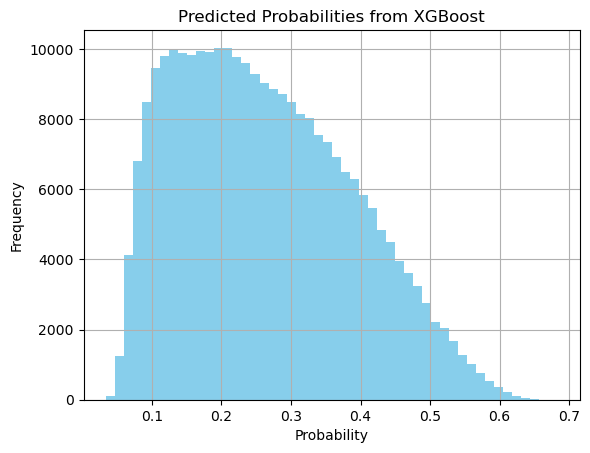

In [19]:
plt.hist(val_pred_prob, bins=50, color='skyblue')
plt.title("Predicted Probabilities from XGBoost")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()